In [2]:
import pandas as pd 
import numpy as np
from joint_pose_vocab import vocab_dict
import matplotlib.pyplot as plt
import os
import cv2
import mediapipe as mp
import time 
import traceback
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
import pickle


TRAIN_SVM = True
TRAIN_FOREST = True
TRAIN_NN = True
TRAIN_KNN = True

os.chdir('../Dataset')
path = os.getcwd()

columns = ['class','l_shoulder','r_shoulder','l_arm','r_arm','l_hip','r_hip','l_knee','r_knee']

Y82_test = pd.read_csv(os.path.join(path,'Y82_testing_new.csv'), header=None)
Y82_train = pd.read_csv(os.path.join(path,'Y82_training_new.csv'), header=None)

L_test = pd.read_csv(os.path.join(path,'L_testing_new.csv'), header=None)
L_train = pd.read_csv(os.path.join(path,'L_training_new.csv'), header=None)

W2_test = pd.read_csv(os.path.join(path,'W2_testing_new.csv'), header=None)
W2_train = pd.read_csv(os.path.join(path,'W2_training_new.csv'), header=None)

Neutral_test = pd.read_csv(os.path.join(path,'Neutral_testing.csv'), header=None)
Neutral_train = pd.read_csv(os.path.join(path,'Neutral_training.csv'), header=None) 

combined_test = pd.concat([L_test, Y82_test, W2_test, Neutral_test])
combined_train = pd.concat([L_train, Y82_train, W2_train, Neutral_train])

combined_test.columns = columns 
combined_train.columns = columns 

combined_test['class'], classes = pd.factorize(combined_test['class'])
combined_train['class'], _ = pd.factorize(combined_train['class'])

''' Filtering out all the extra examples for the cobra class to make a more balanced data set '''
extra_test_cobra_rows = combined_test[combined_test['class'] == 1].sample(130)
extra_train_cobra_rows = combined_train[combined_train['class'] == 1].sample(275)

combined_test = combined_test.drop(extra_test_cobra_rows.index)
combined_train = combined_train.drop(extra_train_cobra_rows.index)

classes = list(classes)

''' These will be the list of classes when giving feedback due to the fact Tree and Warrior have directional variations'''
feedback_classes = classes + ['WarriorII_L', 'WarriorII_R', 'Tree_L_D', 'Tree_R_D', 'Tree_L_U', 'Tree_R_U']
feedback_classes.remove('Neutral')
feedback_classes.remove('Tree')
feedback_classes.remove('WarriorII')

joint_idx_map = {
        0 : 'Left Shoulder',
        1 : 'Right Shoulder',
        2 : 'Left Arm',
        3 : 'Right Arm',
        4 : 'Left Hip',
        5 : 'Right Hip',
        6 : 'Left Knee',
        7 : 'Right Knee'
    }

print(len(joint_idx_map))
print(len(classes))
print(len(columns))
print(len(feedback_classes))
print(len(combined_test))
print(len(combined_train))


8
6
9
9
663
1877


In [3]:
all_combined_df = pd.concat([Y82_train, Y82_test, L_test, L_train, W2_train, W2_test])
all_combined = pd.concat([combined_test, combined_train])

def split_features_labels(df):
    return df.drop('class', axis=1), df['class']
    
for i, c in enumerate(classes):
    print(f"Train: {c} - {len(combined_train[combined_train['class'] == i])}")
    print(f"Test: {c} - {len(combined_test[combined_test['class'] == i])}")
    print()

Train: Tree - 368
Test: Tree - 108

Train: Cobra - 311
Test: Cobra - 122

Train: Chair - 316
Test: Chair - 141

Train: DownDog - 272
Test: DownDog - 105

Train: WarriorII - 383
Test: WarriorII - 135

Train: Neutral - 227
Test: Neutral - 52



# Random Forest Classifer
# 88-89% Maybe 90?
## IDK anymore.. even this is at like 95% lol

In [ ]:
# from sklearn.model_selection import train_test_split // Don't need anymore

if TRAIN_FOREST:
  RANDOM_ORDER_DATA = True 
  MAX_ESTIMATORS = 100
  MAX_DEPTH = 8 

  if RANDOM_ORDER_DATA:
    mutated_train = combined_train.sample(frac=1)
  else:
    mutated_train = combined_train

  X_train, y_train = split_features_labels(mutated_train)
  X_test, y_test = split_features_labels(combined_test)


  forest_classifier = RandomForestClassifier()
  param_grid = {'n_estimators' : np.arange(1, MAX_ESTIMATORS),
                'max_depth' : np.arange(1, MAX_DEPTH),
              }

  forest_classifier_gscv = RandomizedSearchCV(forest_classifier, param_distributions=param_grid, cv=5, n_jobs=-1)

  #fit model to data
  forest_classifier_gscv.fit(X_train, y_train)

  MAX_DEPTH = forest_classifier_gscv.best_params_['max_depth']
  N_ESTIMATORS = forest_classifier_gscv.best_params_['n_estimators']

  best_forest = RandomForestClassifier(max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS)
  best_forest.fit(X_train, y_train)

  pred = best_forest.predict(X_test)
  cm = confusion_matrix(y_test, pred)
  display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  display_confusion_matrix.plot()
  print(classification_report(y_test, pred))

  # Dumping pre-trained model 
  # with open('/Users/mohamed/ZenAI-3YP/AppSite/backend/models/random_forest_92.pkl', 'wb') as f:
  #   pickle.dump(best_forest, f)

# KNN Classifer 
# Eh Around 88%


In [ ]:

if TRAIN_KNN:
    ''' Don't need to do this anymore, cause the dataset is already split (Didn't realise this) '''
    # from sklearn.model_selection import train_test_split
    # 80/20 Split of data, Doesn't randomize, Randomsplit ensures the proportion of classes is the same. 
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    RANDOM_ORDER_DATA = True 

    '''Shuffle data for better resuliting'''
    if RANDOM_ORDER_DATA:
        mutated_train = combined_train.sample(frac=1)
    else:
        mutated_train = combined_train

    X_train, y_train = split_features_labels(mutated_train)
    X_test, y_test = split_features_labels(combined_test)

    max_neighbours = int(np.sqrt(len(X_train)))
    knn_algorithms = ['kd_tree', 'brute', 'ball_tree']


    knn = KNN()

    param_grid = {'n_neighbors' : np.arange(1, max_neighbours),
                'algorithm' : knn_algorithms}

    # Using grid search cross validation to find the best value of K 
    knn_gscv = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1)

    knn_gscv.fit(X_train, y_train)

    ALGORITHM = knn_gscv.best_params_['algorithm']
    N_NEIGHBORS = knn_gscv.best_params_['n_neighbors']

    best_KNN = KNN(algorithm=ALGORITHM, n_neighbors=N_NEIGHBORS)
    best_KNN.fit(X_train, y_train)

    print(f"Fitted KNN Classifer with {ALGORITHM=} and {N_NEIGHBORS=}")


    pred = best_KNN.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    display_confusion_matrix.plot()
    print(classification_report(y_test, pred))


# NN Classifier
## About 87-89% Acc - okay
## WOW WITH JUST A BIT OF DATACLEANING, GETTING SOME MORE EXAMPLES AND FIXING A BUG THE ACCURACY SHOT UP - 94% 

In [ ]:
if TRAIN_NN:
    GRID_SEARCH_PARAMS = True

    '''Shuffle data for better resuliting'''
    RANDOM_ORDER_DATA = True 
    if RANDOM_ORDER_DATA:
        mutated_train = combined_train.sample(frac=1)
    else:
        mutated_train = combined_train

    X_train, y_train = split_features_labels(mutated_train)
    X_test, y_test = split_features_labels(combined_test)

    # Define the parameter distributions to sample from
    param_dist = {
        'hidden_layer_sizes' : [(i, j, k) for i in range(1, 15) for j in range(1, 15) for k in range(1, 15)],
        'solver': ['adam', 'lbfgs'],
        'activation': ['relu', 'logistic'],
        'alpha' : [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    }

    # Initialize MLPClassifier with default values
    mlp = MLPClassifier(max_iter=1000)

    if GRID_SEARCH_PARAMS:
        random_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=3)

        # Train the classifier on your data
        random_search.fit(X_train, y_train)

        # Get the best hyperparameters from the search
        best_params = random_search.best_params_
        print("Best solver: ", best_params['solver'])
        print("Best activation: ", best_params['activation'])
        print("Layers: ", best_params['hidden_layer_sizes'] )
        print("Alpha: ", best_params['alpha'])

        # Use the best hyperparameters to initialize the MLPClassifier
        best_mlp = MLPClassifier(solver=best_params['solver'], activation=best_params['activation'], alpha=best_params['alpha'], hidden_layer_sizes=best_params['hidden_layer_sizes'], max_iter=1000)

        # Train the MLPClassifier on the training data
        best_mlp.fit(X_train, y_train)
    else:
        ''' If you want to skip searching for params. Train NN with values:
        solver: adam
        activation: relu
        layers: 11, 14
        alpha: 0.0001
        '''
        best_mlp = MLPClassifier(solver='adam', activation='relu', alpha=0.0001, hidden_layer_sizes=(11, 14), max_iter=1000)
        best_mlp.fit(X_train, y_train)
        
    pred = best_mlp.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    display_confusion_matrix.plot()
    print(classification_report(y_test, pred))

In [ ]:
print("Best solver: ", best_params['solver'])
print("Best activation: ", best_params['activation'])
print("Layers: ", best_params['hidden_layer_sizes'] )
print("Alpha: ", best_params['alpha'])

#  Dumping pre-trained model 
with open('/Users/mohamed/ZenAI-3YP/AppSite/backend/models/nn_93.pkl', 'wb') as f:
    pickle.dump(best_mlp, f)

In [ ]:
# # Use the best hyperparameters to initialize the MLPClassifier
# best_mlp = MLPClassifier(solver=best_params['solver'], activation=best_params['activation'], alpha=best_params['alpha'], hidden_layer_sizes=best_params['hidden_layer_sizes'], max_iter=1000)

# # Train the MLPClassifier on the training data
# best_mlp.fit(X_train, y_train)


# SVC Grid Search Classifer
## Consistent 90% Sometimes 91%
## After replacing Warrior3 for Warrior2 (Is a hard pose to do, and W3 had too much overlap with the other classes + fixing a 20degree error in the pre-processing the accuracy gained went up by 5% !!)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'C': 5, 'gamma': 'scale'}
Best Score:  0.9136992907801419
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       108
           1       0.91      0.93      0.92       122
           2       0.95      0.94      0.94       141
           3       0.98      0.98      0.98       105
           4       0.96      0.99      0.97       135
           5       0.69      0.73      0.71        52

    accuracy                           0.93       663
   macro avg       0.91      0.91      0.91       663
weighted avg       0.94      0.93      0.93       663



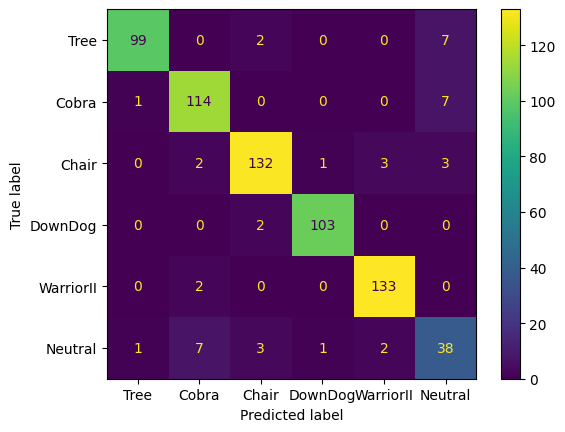

In [4]:
if TRAIN_SVM:
    RANDOM_ORDER_DATA = True 
    RANDOM_CV = False

    '''Shuffle data for better resuliting'''
    if RANDOM_ORDER_DATA:
        mutated_train = combined_train.sample(frac=1)
    else:
        mutated_train = combined_train

    X_train, y_train = split_features_labels(mutated_train)
    X_test, y_test = split_features_labels(combined_test)

    svm = SVC(kernel='rbf') 


    '''Tried search for gamma manually but it appears using scale is just better''' 
    n_features = X_train.shape[1]
    gamma_start = 1 / (n_features * max(X_train.var()))
    gamma_step = 0.005
    gamma_end = gamma_start + (10 * gamma_step)

    ### Doing Grid Search Now ###

    gamma_range = np.arange(gamma_start, gamma_end, gamma_step)
    C_range = [0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    # set the parameter grid for grid search
    param_grid = {
            'C': C_range,
            'gamma' : ['scale', 'auto']
        }

    # perform grid search
    if RANDOM_CV:
        grid = RandomizedSearchCV(svm, cv=5, param_distributions=param_grid, verbose=1)
    else:
        grid = GridSearchCV(svm, cv=5, param_grid=param_grid, verbose=1)
    grid.fit(X_train, y_train)

    # best parameters and score
    print("Best parameters:", grid.best_params_)
    print("Best Score: ", grid.best_score_)

    best_svc = SVC(kernel='rbf', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'], probability=True)

    best_svc.fit(X_train, y_train)

    ''' Plotting '''
    pred = best_svc.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    display_confusion_matrix.plot()
    print(classification_report(y_test, pred))

In [ ]:
#  Dumping pre-trained model 
with open('/Users/mohamed/ZenAI-3YP/AppSite/backend/models/svm_93.pkl', 'wb') as f:
    pickle.dump(best_svc, f)

# Video & Classifer Integration

In [5]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

MIN_DETECTION_CONFIDENCE = 0.5
MIN_TRACKING_CONFIDENCE = 0.5

# All landmark except for hand and face specific
RelevantLandmarks = list(mp_pose.PoseLandmark)[11:17] + list(mp_pose.PoseLandmark)[23:29]

l_hip_landmark_angle_idx = (11,23,25)
r_hip_landmark_angle_idx = (12,24,26)

l_shoulder_landmark_angle_idx = (13,11,23)
r_shoulder_landmark_angle_idx = (14,12,24)

l_arm_landmark_angle_idx = (15,13,11)
r_arm_landmark_angle_idx = (16,14,12)

l_knee_landmark_angle_idx = (23,25,27)
r_knee_landmark_angle_idx = (24,26,28)

#Match idx of RelevantLandmarks 
angle_idxs_required = [
    l_shoulder_landmark_angle_idx,
    r_shoulder_landmark_angle_idx,
    
    l_arm_landmark_angle_idx,
    r_arm_landmark_angle_idx,
    
    l_hip_landmark_angle_idx,
    r_hip_landmark_angle_idx,
    
    l_knee_landmark_angle_idx,
    r_knee_landmark_angle_idx
]

skip_landmark = {
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_WRIST,
    mp_pose.PoseLandmark.LEFT_WRIST
}

# landmarkStr = {
#     mp_pose.PoseLandmark.NOSE : "NOSE",
#     mp_pose.PoseLandmark.LEFT_EYE_INNER : "LEFT_EYE_INNER",
#     mp_pose.PoseLandmark.LEFT_EYE : "LEFT_EYE",
#     mp_pose.PoseLandmark.LEFT_EYE_OUTER : "LEFT_EYE_OUTER",
#     mp_pose.PoseLandmark.RIGHT_EYE_INNER : "RIGHT_EYE_INNER",
#     mp_pose.PoseLandmark.RIGHT_EYE : "RIGHT_EYE",
#     mp_pose.PoseLandmark.RIGHT_EYE_OUTER : "RIGHT_EYE_OUTER",
#     mp_pose.PoseLandmark.LEFT_EAR : "LEFT_EAR",
#     mp_pose.PoseLandmark.RIGHT_EAR : "RIGHT_EAR",
#     mp_pose.PoseLandmark.MOUTH_LEFT : "MOUTH_LEFT",
#     mp_pose.PoseLandmark.MOUTH_RIGHT : "MOUTH_RIGHT",
#     mp_pose.PoseLandmark.LEFT_SHOULDER : "LEFT_SHOULDER",
#     mp_pose.PoseLandmark.RIGHT_SHOULDER : "RIGHT_SHOULDER",
#     mp_pose.PoseLandmark.LEFT_ELBOW : "LEFT_ELBOW",
#     mp_pose.PoseLandmark.RIGHT_ELBOW : "RIGHT_ELBOW",
#     mp_pose.PoseLandmark.LEFT_WRIST : "LEFT_WRIST",
#     mp_pose.PoseLandmark.RIGHT_WRIST : "RIGHT_WRIST",
#     mp_pose.PoseLandmark.LEFT_PINKY : "LEFT_PINKY",
#     mp_pose.PoseLandmark.RIGHT_PINKY : "RIGHT_PINKY",
#     mp_pose.PoseLandmark.LEFT_INDEX : "LEFT_INDEX",
#     mp_pose.PoseLandmark.RIGHT_INDEX : "RIGHT_INDEX",
#     mp_pose.PoseLandmark.LEFT_THUMB : "LEFT_THUMB",
#     mp_pose.PoseLandmark.RIGHT_THUMB : "RIGHT_THUMB",
#     mp_pose.PoseLandmark.LEFT_HIP : "LEFT_HIP",
#     mp_pose.PoseLandmark.RIGHT_HIP : "RIGHT_HIP",
#     mp_pose.PoseLandmark.LEFT_KNEE : "LEFT_KNEE",
#     mp_pose.PoseLandmark.RIGHT_KNEE : "RIGHT_KNEE",
#     mp_pose.PoseLandmark.LEFT_ANKLE : "LEFT_ANKLE",
#     mp_pose.PoseLandmark.RIGHT_ANKLE : "RIGHT_ANKLE",
#     mp_pose.PoseLandmark.LEFT_HEEL : "LEFT_HEEL",
#     mp_pose.PoseLandmark.RIGHT_HEEL : "RIGHT_HEEL",
#     mp_pose.PoseLandmark.LEFT_FOOT_INDEX : "LEFT_FOOT_INDEX",
#     mp_pose.PoseLandmark.RIGHT_FOOT_INDEX : "RIGHT_FOOT_INDEX"
# }

def calc_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)    
    c = np.array(c)   
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle > 180.0:
        angle = 360-angle
    
    return angle 

In [6]:

def classify_pose(example, classifer):
    example = pd.DataFrame(np.array(example).reshape(1, -1), columns=columns[1:])

    if classifer == 'KNN':
        probabilty_classes = best_KNN.predict_proba(example)
    elif classifer == 'Forest':
        probabilty_classes = best_forest.predict_proba(example)
    elif classifer == 'SVM':
        probabilty_classes = best_svc.predict_proba(example)
    elif classifer == 'NN':
        probabilty_classes = best_mlp.predict_proba(example)
    else:
        raise Exception("Please enter valid classifer. Currently only ('KNN' | 'Forest' | 'NN' | 'SVM')")

    
    prob_predicted_classes = [] 
    for class_idx, prob in enumerate(probabilty_classes[0]):
        prob_predicted_classes.append((classes[class_idx], prob))
        
    prob_predicted_classes.sort(key = lambda x: x[1], reverse=True)
    
    # Get the highest predicted class 
    predicted_class = prob_predicted_classes[0]
    
    return (predicted_class[0], predicted_class[1], sorted(prob_predicted_classes, key = lambda x: x[1], reverse=True))

true_dd = [142.37777553207002, 139.64800875518796, 169.89242687253358, 167.7532036061619, 54.37618561971105, 51.302522256267395, 179.5812861697249, 172.5236523095383]
# Sanity test classification 
# classify_pose([8.390697637127042, 13.364568331384618, 16.49759248897499, 153.50000646379374, 173.20291493738577, 199.52935190007366, 179.00845878279233, 198.25172013734928], classifer='SVM')

# for x in fuckme:
#     print(classify_pose(x, classifer='SVM')[0])
# print(classify_pose(true_dd, classifer='SVM')[0])


print(classify_pose([174.84570424165975, 175.82856689622392, 170.09879634163005, 170.10136198815954, 57.08929604087008, 57.37735077817062, 139.1993104827667, 138.84582421154903], classifer='SVM'))

('DownDog', 0.9294596830685864, [('DownDog', 0.9294596830685864), ('Chair', 0.03953665136160484), ('Cobra', 0.024819552333923186), ('Neutral', 0.0036079509823785153), ('WarriorII', 0.0018777636270732954), ('Tree', 0.00069839862643355)])


In [7]:
pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train)

def extract_pca_2d(example):
    example = pd.DataFrame(np.array(example).reshape(1, -1), columns=columns[1:])
    return pca.transform(example)

def unnormalize_cords(x, y, fw, fh):
    return tuple(np.multiply([x, y], [fw, fh]).astype(int))

# Getting the ideal angles into a dataframe
## Currently the method just gets the ideal images and finds the angles in those images and uses that as the ideal example.
## A more sophisiticated method may be getting a large amount of ideal examples and averaging over all of their angles to get a mean ideal angle for each key point. Ideal

# Edits: 
## There are now two ways of calculating the ideal angle - one is more sophisticated and splits up WarriorII and Tree into 2 different 'subclasses' one for facing left and one for facing right. This was done as the score someone would recieve for doign these exercises wouldn't be accurate as we previously didn't take into account which variation they did it

## The old way of getting the average angles still exist and we simply just need to the toggle the `OLD_IDEAL_ANGLES` variable.

In [8]:
OLD_IDEAL_ANGLES = False 

if OLD_IDEAL_ANGLES:
    # Depricated since we're now differentiate left and right warrior 
    ''' Might end up going back to this'''
    ideal_angles = pd.read_csv('../DemoImages/Ideal_Angles.csv', header=None)
    ideal_angles.columns = columns 

    ideal_angles_map_single = {pose : ideal_angles[ideal_angles['class'] == pose].values.tolist()[0][1:] for pose in classes}

    ''' Finding the average for all poses'''
    ideal_angles_map_average = {pose : combined_train[combined_train['class'] == pose_idx].mean(axis=0).tolist()[1:] for pose_idx, pose in enumerate(classes) }

else:
    ideal_angles = pd.read_csv('../DemoImages/joint_angles.csv', header=None)
    ideal_angles.columns = columns
    ideal_angles_map_single = {pose : ideal_angles[ideal_angles['class'] == pose].values.tolist()[0][1:] for pose in feedback_classes}
    ideal_angles_map_single['Neutral'] = []
    
    ''' Finding the average for all poses except WarriorII and Tree. These need to be dealt in a special case explained in the next section'''
    ideal_angles_map_average = {pose : combined_train[combined_train['class'] == pose_idx].mean(axis=0).tolist()[1:] for pose_idx, pose in enumerate(classes) if pose not in {'WarriorII', 'Tree'}}

    ''' Splitting Warrior into Warrior L and Warrior R -- Setting the threshold to 170 gives the most equal 5050 split (180:196) and makes sense'''
    w2index = classes.index('WarriorII')
    Right_WarriorII = combined_train[(combined_train['class'] == w2index) & (combined_train['l_knee'] > 170)]
    Left_WarriorII = combined_train[(combined_train['class'] == w2index) & (combined_train['l_knee'] <= 170)]
    

    ideal_angles_map_average['WarriorII_R'] = Right_WarriorII.mean(axis=0).tolist()[1:]
    ideal_angles_map_average['WarriorII_L'] = Left_WarriorII.mean(axis=0).tolist()[1:]

    ''' Splitting Tree into Tree L and Tree R -> The split of is 100:250 (L:R) even while changing the degree threshold this value doesn't change much.'''
    ''' Potentially gonna have to split into Arms-Up Tree and Arms-Down Tree since the training data may include both poses with arms up and poses with arms down'''
    tree_idx = classes.index('Tree')

    Left_Tree_Down = combined_train[(combined_train['class'] == tree_idx) & (combined_train['l_knee'] <= 90) & (combined_train['l_shoulder'] <= 90) ]
    Right_Tree_Down = combined_train[(combined_train['class'] == tree_idx) & (combined_train['l_knee'] > 90) & (combined_train['l_shoulder'] <= 90) ]
    Left_Tree_Up = combined_train[(combined_train['class'] == tree_idx) & (combined_train['l_knee'] <= 90) & (combined_train['l_shoulder'] > 90) ]
    Right_Tree_Up = combined_train[(combined_train['class'] == tree_idx) & (combined_train['l_knee'] > 90) & (combined_train['l_shoulder'] > 90) ]


    # min_shoulder = combined_train[(combined_train['class'] == tree_idx) & (combined_train['l_knee'] > 120)]['l_shoulder'].min()
    # max_shoulder = combined_train[(combined_train['class'] == tree_idx) & (combined_train['l_knee'] > 120)]['l_shoulder'].max()

    # print(min_shoulder, max_shoulder)
    
    ideal_angles_map_average['Tree_R_D'] = Right_Tree_Down.mean(axis=0).tolist()[1:]
    ideal_angles_map_average['Tree_L_D'] = Left_Tree_Down.mean(axis=0).tolist()[1:]
    ideal_angles_map_average['Tree_R_U'] = Right_Tree_Up.mean(axis=0).tolist()[1:]
    ideal_angles_map_average['Tree_L_U'] = Left_Tree_Up.mean(axis=0).tolist()[1:]
    
ideal_angles_map = ideal_angles_map_single
ideal_angles_map['Tree_L_D']

[11.60477986099238,
 16.318277028528883,
 31.738719008798288,
 32.419664276734686,
 130.53068607071847,
 177.58393886696754,
 48.30735574812036,
 179.3469550075096]

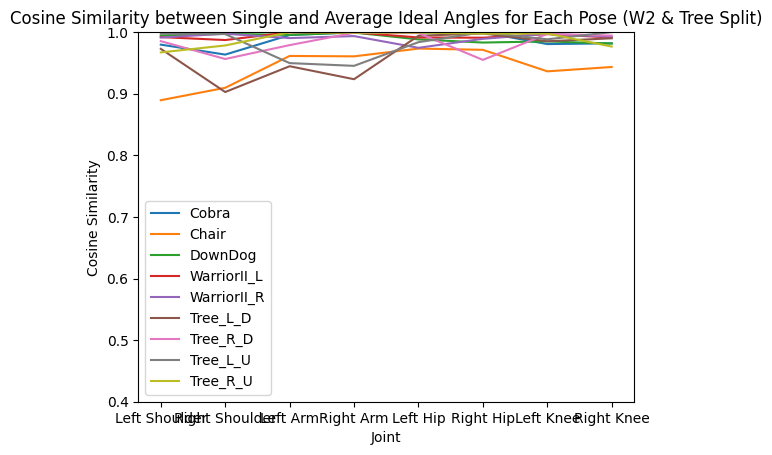

In [9]:
def cosine_similarity(angle1, angle2, difficulty):
    """
    Calculates the cosine similarity between two angles in degrees.
    """
    angle1_rad = np.deg2rad(angle1)
    angle2_rad = np.deg2rad(angle2)
    cos_sim = np.cos(angle1_rad - angle2_rad)

    # Rescale the cosine similarity to be between 0 and 1, with values closer to 0 indicating a worse match
    sim_rescaled = (cos_sim + 1) / 2
    
    ''' Returing the score raised to the n'th power, where n determines how sensitive the score is.'''
    return sim_rescaled**difficulty

# Define the x-axis values (the angle indexes)
x = joint_idx_map.values()

# Set up the figure and axis for the plot
fig, ax = plt.subplots()

# Plot the cosine similarity values for each pose (excluding 'Neutral')
if OLD_IDEAL_ANGLES:
    poses = classes
else:
    poses = feedback_classes

for pose in poses:
    if pose == 'Neutral':
        continue
    
    cosine_similarities = [cosine_similarity(single, avg, 1) for single, avg in zip(ideal_angles_map_single[pose], ideal_angles_map_average[pose])]
    ax.plot(x, cosine_similarities, label=pose)

# Set the plot title and labels for the x- and y-axes
ax.set_title('Cosine Similarity between Single and Average Ideal Angles for Each Pose (W2 & Tree Split)')
ax.set_xlabel('Joint')
ax.set_ylabel('Cosine Similarity')

# Set the y-axis limits to be between 0 and 1
ax.set_ylim([0.4, 1])
ax.legend()
plt.show()

In [10]:
if OLD_IDEAL_ANGLES:
    poses = classes
else:
    poses = feedback_classes
print(list(joint_idx_map.values()))
for pose in poses:
    
    cosine_similarities = [cosine_similarity(single, avg, 1) for single, avg in zip(ideal_angles_map_single[pose], ideal_angles_map_average[pose])]
    print(pose)
    print(f'Single Example Angles: {ideal_angles_map_single[pose]}')
    print(f'Average over training set: {ideal_angles_map_average[pose]}')
    print(f'Cosine Similarities: {cosine_similarities}')
    print()

['Left Shoulder', 'Right Shoulder', 'Left Arm', 'Right Arm', 'Left Hip', 'Right Hip', 'Left Knee', 'Right Knee']
Cobra
Single Example Angles: [10.61945547274164, 5.194255493236426, 151.21999330831113, 139.77911924943177, 124.96859674521366, 123.00461585465686, 173.39860978441524, 171.9159725072726]
Average over training set: [27.0069252733119, 27.217534630225078, 143.31593803858522, 141.45244964630223, 122.31046308681675, 121.25187456591638, 157.38678327974273, 156.40727967845658]
Cosine Similarities: [0.9796878488829939, 0.9635157881435581, 0.9952498663667715, 0.9997867803258405, 0.9994620146164757, 0.9997660642961838, 0.9806023903780291, 0.9817949485583948]

Chair
Single Example Angles: [172.20262779788357, 170.926950357259, 170.52675167515667, 169.1144317619259, 127.0647873154224, 125.65128150628443, 141.9588268198319, 139.07559917412507]
Average over training set: [133.36473756329113, 135.9382398101266, 147.84248525316457, 146.23515224683544, 108.25009129746836, 106.1283663607595, 

# Some extra data post-processing
## WarriorII and Tree are unique in the sense that the ideal angles are different if you're doing the left or right variation of the exercise
### My method of fixing this is, for each example we detect if it's the left variation or right variation and create a seperate entry in the map depending on that.

In [11]:
''' Suprisngly using the same angle of 120 as a rough mid point between allowing 30degrees away from a 90degree is reasonable for both W2 and Tree
But I will leave the explicit code in to add to the readabilty.'''
def is_left_pose(pose, angles):

    ''' The standard index of left knee in the angles'''
    l_knee = 6 
  
    if pose == 'WarriorII':
        return angles[l_knee] <= 170 
    elif pose == 'Tree':
        return angles[l_knee] <= 90
    else:
        raise Exception("Only poses supported are 'WarriorII' and 'Tree'")
    
def is_down_tree(angles):
    l_shoulder = 0
    return angles[l_shoulder] <= 90

# Caluclate the total score of a users score. Currently using trivial MSE -- will get more sophisitcated as development continues 

In [12]:
''' This didn't work haha'''
def calculate_pose_score(ideal_example, user_example):

    tot = 0 
    for x in zip(ideal_example, user_example):

        tmp_score = 100 * (1 - (np.abs((x[0] - x[1]))/360))
        tot += tmp_score
        # print(tmp_score)
    
    # print(tot//len(ideal_example))

''' Using Cosine Similarty Method --- Not exactly the best implementation

Convert the two lists of angles into numpy arrays, and then we calculate the dot product of the two arrays and divide it by the product of their norms. 
This gives us the cosine similarity. Finally, we return a score between 0 and 100 by adding 1 to the cosine similarity and multiplying it by 50. 
The result will be a number between 0 and 100, where 100 indicates that the vectors are identical and 0 indicates that the vectors are completely dissimilar.'''
def calculate_pose_score(current_ideal_angles, pose_relevant_landmark_angles):
    current_ideal_angles = np.array(current_ideal_angles)
    pose_relevant_landmark_angles = np.array(pose_relevant_landmark_angles)

    cos_sim = np.dot(current_ideal_angles, pose_relevant_landmark_angles) / (np.linalg.norm(current_ideal_angles) * np.linalg.norm(pose_relevant_landmark_angles))

    return ((cos_sim + 1) * 50)/100


def cosine_similarity(angle1, angle2, difficulty):
    """
    Calculates the cosine similarity between two angles in degrees.
    """
    angle1_rad = np.deg2rad(angle1)
    angle2_rad = np.deg2rad(angle2)
    cos_sim = np.cos(angle1_rad - angle2_rad)

    ''' Returing the score raised to the n'th power, where n determines how sensitive the score is.'''
    sim_rescaled = abs(cos_sim) ** difficulty
    
    ''' Returning weather the original cosine similarity was positive or negative to indicate which direction to turn'''
    return (cos_sim < 0, sim_rescaled)

### Helper Functions

In [13]:
''' Doesn't work as intended'''
def display_error_image(frame_width, frame_height):
    # Create a black image to use as the background
    image = np.zeros((frame_height, frame_width, 3), np.uint8)

    # Add text to the image
    text = "Cannot detect user, please get in frame"
    font = FONT
    font_scale = 2
    font_thickness = 5
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_x = int((frame_width - text_size[0]) / 2)
    text_y = int((frame_height + text_size[1]) / 2)
    cv2.putText(image, text, (text_x, text_y), font, font_scale, WHITE_TEXT, font_thickness, LINE)

    # Display the image
    cv2.imshow("ZenAI", image)
    time.sleep(1)

''' Render pose estimated from mediapipe'''
def render_skeleton(image, landmarks):
    mp_drawing.draw_landmarks(
        image, 
        landmarks,
        mp_pose.POSE_CONNECTIONS,                
        mp_drawing.DrawingSpec(color=(50, 145, 168), circle_radius=2, thickness=2),
        mp_drawing.DrawingSpec(color=(209, 192, 42), circle_radius=2, thickness=2)
    )

''' Extracting the angles for each of the relevant joints in the frame'''
def extract_joint_angles(pose_landmarks):
    ''' Converting landmarks into angles'''
    pose_relevant_landmark_angles = []
    # Going through all relevant landmarks, extracting their key angles
    # Calculating the angle then adding to array 
    for i1, i2, i3 in angle_idxs_required:
        
        fst = (pose_landmarks.landmark[i1].x, pose_landmarks.landmark[i1].y)
        snd = (pose_landmarks.landmark[i2].x, pose_landmarks.landmark[i2].y)
        thrd = (pose_landmarks.landmark[i3].x, pose_landmarks.landmark[i3].y)
        
        pose_relevant_landmark_angles.append(calc_angle(fst, snd, thrd))

    pose_relevant_landmark_angles_visual = np.around(pose_relevant_landmark_angles, 2).astype(str).tolist()

    return pose_relevant_landmark_angles, pose_relevant_landmark_angles_visual

''' Extracting the x, y cords of each joint'''
def extract_joint_cords(pose_landmarks):
    # Getting cords of the landmarks FOR ANGLES WE CALC'D CORDS FOR. 
    # If any any of this landamrks have a visbility < MIN_DETECTION_CONFIDENCE. 
    # Display an error / throw an error saying you need the whole body in the frame
    pose_relevant_landmark_cords = [] 
    for _, idx, _ in angle_idxs_required:
        if idx in skip_landmark:
            continue
        
        current_landmark = pose_landmarks.landmark[idx]
        
        pose_relevant_landmark_cords.append([current_landmark.x, current_landmark.y])

    return pose_relevant_landmark_cords

def create_live_video_display(image, pose_landmarks, classified_pose, classified_pose_confidence, frame_width, frame_height):
    #Revert image color 
    image.flags.writeable = True 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    render_skeleton(image, pose_landmarks)
    
    display_text = 'Neutral' if classified_pose == 'Neutral' else f'Confidence: {classified_pose} {classified_pose_confidence*100:.2f}%'
    
    cv2.putText(image, display_text, unnormalize_cords(0.1, 0.1, frame_width, frame_height), FONT, 2, (125, 0, 0), 2, LINE) 

    return image

    
def gradient(score):

    """Converts a score between 0 and 1 to an RGB value that is a gradient between red and green."""
    r = int(max(0, min(255, (1 - score*3) * 255)))
    g = int(max(0, min(255, score * 255)))
    b = 0
    return (b, g, r)



def generate_user_pose_feedback(joint, user_angle, ideal_angle, score, is_greater_than_90, joint_idx, pose):
    """
    Generates feedback for the user's pose based on the joint, score, and angle difference.
    """
    if score >= 0.95:
        return f"Great job! Your {joint} is in the ideal position."
    else:
        rough_ideal_angle = min([0, 20, 45, 60, 90, 120, 135, 160, 180], key=lambda x: abs(x-int(ideal_angle)))
        rough_angle = round(float(user_angle), -1)


        if score <= 0.3:
            severity = 'a lot'
        elif 0.3 < score <= 0.6:
            severity = 'a fair bit'
        else:
            severity = 'a little'


        action = [pose][joint_idx][0] if is_greater_than_90 else vocab_dict[pose][joint_idx][1]
        
        common_error, common_fix = vocab_dict[pose][joint_idx][2].split(',')

        feedback_suggestion = {
            'raw' : f"{joint} | U: {rough_angle} / {user_angle} | G: {rough_ideal_angle} / {ideal_angle:.2f} | S: {score:.2f} | P: {pose}",
            'formatted' : [f'Your {joint} is out of place.', 
                           f'You should aim to get your {joint} to roughly {rough_ideal_angle}',
                           f'and it\'s currently around a {rough_angle}',
                           f'You can do this by {action} your {joint} {severity} | S: {score:.2f}',
                           f'A common error here is: {common_error}',
                           f'{common_fix}'
                           ]
        }

        return feedback_suggestion


def calculate_center_of_gravity(pose_landmarks, fw, fh):
    left_hip = pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP]
    right_hip = pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]
    center_hip = (left_hip.x + right_hip.x) / 2, (left_hip.y + right_hip.y) / 2

    left_shoulder = pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER]
    right_shoulder = pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]
    center_shoulder = (left_shoulder.x + right_shoulder.x) / 2, (left_shoulder.y + right_shoulder.y) / 2

    center_of_gravity = ((center_hip[0] + center_shoulder[0]) / 2, (center_hip[1] + center_shoulder[1]) / 2)


    arrow_start = (int(center_of_gravity[0] * fw), int(center_of_gravity[1] * fh))
    arrow_end = (arrow_start[0], int(fh * 0.8))


    return (arrow_start, arrow_end)


def create_skeleton_video_display(pose_landmarks, classified_pose, classified_pose_confidence, joint_angles_rounded, joint_cords, joint_scores, elapsed_time, reference_image, ideal_angles, feedback_pose, frame_width, frame_height):
    DISPLAY_ANGLE_SCORE = True

    ''' Creating the window that displays the feedback'''
    feedback_window = np.zeros((frame_height, frame_width, 3), np.uint8)

    ''' Create a black image to use as the background'''
    black_image = np.zeros((frame_height, frame_width, 3), np.uint8)

    ''' Render the skeleton on the black image ''' 
    render_skeleton(black_image, pose_landmarks)
    
    ''' Calculate center of gravity
        and draw an arrow from the center of gravity to the floor '''
    arrow_start, arrow_end = calculate_center_of_gravity(pose_landmarks, frame_width, frame_height)
    cv2.arrowedLine(black_image, arrow_start, arrow_end, (0, 255, 0), 5)
    
    
    ''' Only display the score information of a pose if it's not a Neutral pose'''
    if classified_pose != 'Neutral':
        ''' 
        Calculating the best, worst and average scores
    
        Calculation of the overall score may be changed to include a weighted mean
        where there will be a pre-defined weight vector of joints for each pose.
        '''
        scores_list = [score[1] for score in joint_scores]
        total_pose_score = np.average(scores_list)
        best_joint_idx = np.argmax(scores_list)
        worst_joint_idx = np.argmin(scores_list)

        improvement_suggestions = dict()
        ''' Draw red circles on the joints with size proportional to the joint score ''' 
        for i, (x, y) in enumerate(joint_cords):
            diff_over_90, score = joint_scores[i]
            joint = joint_idx_map[i]
            
            radius = int((100 * (1 - score)) * 0.5)

            black_image = cv2.circle(black_image, unnormalize_cords(x, y, frame_width, frame_height), radius, (0, 0, 255), -1)

            ''' Highlighting the worst and best joint in the users pose
                & Display the joint score for each joint on the right side of the frame'''

            if DISPLAY_ANGLE_SCORE:
                if i == best_joint_idx:
                    cv2.putText(black_image, f'Best: {joint}: {score*100:.2f}% {joint_angles_rounded[i]} ', unnormalize_cords(0.53, 0.2 + (i / (1.25 * len(joint_cords))), frame_width, frame_height), FONT, 1, (0, 255, 0), 2, LINE)
                elif i == worst_joint_idx:
                    cv2.putText(black_image, f'Worst: {joint}: {score*100:.2f}% {joint_angles_rounded[i]} ', unnormalize_cords(0.53, 0.2 + (i / (1.25 * len(joint_cords))), frame_width, frame_height), FONT, 1, (0, 0, 255), 2, LINE)
                else:
                    cv2.putText(black_image, f'{joint}: {score*100:.2f}% {joint_angles_rounded[i]}', unnormalize_cords(0.60, 0.2 + (i / (1.25 * len(joint_cords))), frame_width, frame_height), FONT, 1, WHITE_TEXT, 2, LINE)

            improvement_suggestions[i] = generate_user_pose_feedback(joint, joint_angles_rounded[i], ideal_angles[i], score, diff_over_90, i, feedback_pose)


        ''' Draw the rectangle on the left side of the screen '''
        rect_x, rect_y = unnormalize_cords(0.05, 1, frame_width, frame_height)
        rect_width, rect_height = int(frame_width * 0.05), int(total_pose_score * frame_height)
        cv2.rectangle(black_image, (rect_x, rect_y - rect_height), (rect_x + rect_width, rect_y), gradient(total_pose_score), -1)

        ''' Displaying the average of all the users scores individual angles'''
        cv2.putText(black_image, f'Pose Score: {total_pose_score*100:.2f}%', unnormalize_cords(0.42, 0.1, frame_width, frame_height), FONT, 2, WHITE_TEXT, 2, LINE)
        
        ''' Displaying how long the user has held the pose'''
        cv2.putText(black_image, f'Time held: {elapsed_time:.2f} seconds', unnormalize_cords(0.1, 0.1, frame_width, frame_height), FONT, 1, WHITE_TEXT, 2, LINE)
    
        ''' 
        Generate Imrpovements
        '''
        # for i, suggestion in enumerate(improvement_suggestions.values()):
        #     y_placement = 0.2 + (i / (1.25 * len(improvement_suggestions)))
        #     cv2.putText(feedback_window, suggestion, unnormalize_cords(0.05, y_placement, frame_width, frame_height), FONT, 1, WHITE_TEXT, 2, LINE)
        formatted_suggestion = improvement_suggestions[worst_joint_idx]['formatted']

        ''' Generate the improvement suggestion for the worst joint'''
        cv2.putText(feedback_window, improvement_suggestions[worst_joint_idx]['raw'], unnormalize_cords(0.05, 0.1, frame_width, frame_height), FONT, 1, WHITE_TEXT, 2, LINE)

        cv2.putText(feedback_window, formatted_suggestion[0], unnormalize_cords(0.05, 0.2, frame_width, frame_height), FONT, 1, WHITE_TEXT, 2, LINE)

        cv2.putText(feedback_window, formatted_suggestion[1], unnormalize_cords(0.05, 0.3, frame_width, frame_height), FONT, 1, WHITE_TEXT, 2, LINE)
        cv2.putText(feedback_window, formatted_suggestion[2], unnormalize_cords(0.05, 0.35, frame_width, frame_height), FONT, 1, WHITE_TEXT, 2, LINE)
        
        cv2.putText(feedback_window, formatted_suggestion[3], unnormalize_cords(0.05, 0.45, frame_width, frame_height), FONT, 1, WHITE_TEXT, 2, LINE)

        cv2.putText(feedback_window, formatted_suggestion[4], unnormalize_cords(0.05, 0.55, frame_width, frame_height), FONT, 1, WHITE_TEXT, 2, LINE)
        cv2.putText(feedback_window, formatted_suggestion[5], unnormalize_cords(0.05, 0.6, frame_width, frame_height), FONT, 1, WHITE_TEXT, 2, LINE)

        ''' Pie Chart indiciating how well the joint is'''
        score_angle = int(joint_scores[worst_joint_idx][1] * 360)
        pie_center = unnormalize_cords(0.1, 0.8, frame_width, frame_height)
        cv2.ellipse(feedback_window, pie_center, (50, 50), 0, 0, score_angle, (0, 255, 0), -1)
        cv2.ellipse(feedback_window, pie_center, (50, 50), 0, score_angle, 360, (0, 0, 255), -1)
        cv2.putText(feedback_window, f'{joint_idx_map[worst_joint_idx]} Score: {joint_scores[worst_joint_idx][1]*100:.0f}%', unnormalize_cords(0.1+0.05, 0.8+0.05, frame_width, frame_height), FONT, 1, WHITE_TEXT, 2, LINE)


        ''' uncommoent '''
        # with open('test_output.txt', 'a') as f:
        #     f.write(formatted[0])
        #     f.write(formatted[1])
        #     f.write(formatted[2])
        #     f.write(formatted[3])
        ''' '''
        # diff_over_90, score = joint_scores[worst_joint_idx]
        # improvement_suggestion = generate_user_pose_feedback(joint_idx_map[worst_joint_idx], score, diff_over_90)
        
    ''' Displaying the reference image in low opacity'''
    reference_image = cv2.resize(reference_image, (frame_width, frame_height))
    blended_image = cv2.addWeighted(black_image, 0.9, reference_image, 0.1, 0)

    ''' Write the joint angles on the black image ''' 
    for i, angle in enumerate(joint_angles_rounded):
        x, y = joint_cords[i]
        cv2.putText(blended_image, angle, unnormalize_cords(x, y, frame_width, frame_height), FONT, 0.5, WHITE_TEXT, 2, LINE)

    return feedback_window, blended_image


In [ ]:
''' Plotting 2D Projection'''
def plot_live_data(points, ax):
    cords = [(extract_pca_2d(x[0]), x[1]) for x in points]

    class_labels = [point[1] for point in cords]

    unique_classes = set(class_labels)
    colors = {class_label: index for index, class_label in enumerate(unique_classes)}
    mat_colors = ['b', 'r', 'g', 'c', 'm', 'y']

    ax.clear()

    for class_label in unique_classes:
        x_v = [point[0][0][0] for idx, point in enumerate(cords) if class_labels[idx] == class_label]
        y_v = [point[0][0][1] for idx, point in enumerate(cords) if class_labels[idx] == class_label]

        c_ = [mat_colors[colors[class_label]] for _ in range(len(x_v))]
        ax.scatter(x_v, y_v, c=c_, label=class_label, s=3)

    ax.legend()

# Main video / classification loop

In [16]:
last_pose = 'Neutral'
start_time = 0

PLAY_FEED = True

''' CV2 PutText globals'''
FONT = cv2.FONT_HERSHEY_SIMPLEX
LINE = cv2.LINE_AA
WHITE_TEXT = (255, 255, 255)
BLACK_TEXT = (0, 0, 0)

CLASSIFIER = 'SVM'

MIN_DETECTION_CONFIDENCE = 0.5
MIN_TRACKING_CONFIDENCE = 0.5

VERBOSE = False
PLOT_2D = True

EXAMPLE_POSE_IMAGE = {i.replace('.jpeg', '') : cv2.imread(f"../DemoImages/{i}", 1) for i in os.listdir("../DemoImages")}
DEMO_POSE_VIDEOS = {f.replace('.mp4', '') : '../demo_videos/' + f  for f in os.listdir('../demo_videos')}
DISPLAY_DEMO = False
SCORE_DIFFICULTY = 10

frame_width = 1280
frame_height = 720

# This is just storing each frame in a real life demonstration as a projected point in 2D using pca 
# Which then decision boundaries will be plotted of the SVM model used to determin how someone moves around in a real life example
PCA_2D_POINTS = [] 


In [17]:
if PLAY_FEED:
    with mp_pose.Pose(min_detection_confidence=MIN_DETECTION_CONFIDENCE, min_tracking_confidence=MIN_TRACKING_CONFIDENCE, static_image_mode=False) as pose:
    
        if DISPLAY_DEMO:
            cap = cv2.VideoCapture(DEMO_POSE_VIDEOS['Downdog'])
        else:
            cap = cv2.VideoCapture(0) # Captures live video feed 

        cap.set(cv2.CAP_PROP_FRAME_WIDTH, frame_width)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_height)
        
        while cap.isOpened():
            suc, frame = cap.read() 
            if not suc: 
                print("Frame empty..")
                continue 
            
            #Recolor image 
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            
            try: 
                ''' Detect pose and extract angles / cords ''' 
                result = pose.process(image=image) 

                ''' If media pipe libray can't detect any poses, just display the normal image back.'''
                if not result.pose_landmarks:# or any(landmark is None for landmark in result.pose_landmarks.landmark):
                    image.flags.writeable = True 
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

                    correct_example_image = cv2.resize(EXAMPLE_POSE_IMAGE[classified_pose], (frame_width, frame_height))   
                    black_image = np.zeros((frame_height, frame_width, 3), np.uint8)
                    cv2.putText(black_image, "User not detected.", unnormalize_cords(0.1, 0.5, frame_width, frame_height), FONT, 3, WHITE_TEXT, 4, LINE)
                    cv2.putText(black_image, "Please get in frame.", unnormalize_cords(0.1, 0.6, frame_width, frame_height), FONT, 3, WHITE_TEXT, 4, LINE)
                    
                else:                    
                    pose_landmarks = result.pose_landmarks

                    joint_angles, joint_angles_rounded = extract_joint_angles(pose_landmarks)
                    joint_cords = extract_joint_cords(pose_landmarks)
                    
                    ''' Classification of Pose''' 
                    classified_pose, classified_pose_confidence, prediction_probabilites = classify_pose(joint_angles, CLASSIFIER)
                    ''' We take the pose the user is doing to be neutral if either it's classified as a neutral pose or the confidence of the classified pose is < 70%'''
                    classified_pose = classified_pose if classified_pose_confidence >= 0.70 else 'Neutral'

                    # Get the current time and if the pose has changed, update the start time to be the current time
                    current_time = time.time()
                    if classified_pose != last_pose:
                        start_time = current_time
                        last_pose = classified_pose

                    # If the pose did just change, then this value will be 0 
                    elapsed_time = current_time - start_time

                    feedback_pose = classified_pose
                    
                    ''' 
                        It was a waste of computation to calculate the angle score for a neutral pose

                        and if the pose is Warrior or Tree we need to add another layer of detail when scoring angles 
                        as the ideal angles of someone doing a Left Tree or Right Tree are different. 
                        This makes the feedback dynamic and even allows for variation in the tree pose specifically
                    '''

                    if classified_pose == 'Neutral':
                        angles_score = []
                    elif classified_pose in {'WarriorII', 'Tree'}:
                        left = is_left_pose(classified_pose, joint_angles)
                        right = not left

                        if classified_pose == 'WarriorII':
                            if left:
                                feedback_pose = 'WarriorII_L'
                            else:
                                feedback_pose = 'WarriorII_R'
                            

                        elif classified_pose == 'Tree':
                            down = is_down_tree(joint_angles) 
                            up = not down 

                            if left and down:
                                feedback_pose = 'Tree_L_D'
                            elif left and up:
                                feedback_pose = 'Tree_L_U'
                            elif right and down:
                                feedback_pose =  'Tree_R_D'
                            elif right and up:
                                feedback_pose = 'Tree_R_U'              

                        cv2.putText(image, f'FbP: {feedback_pose}', unnormalize_cords(0.1, 0.9, frame_width, frame_height), FONT, 2, WHITE_TEXT, 4, LINE)

                    ideal_angles = ideal_angles_map[feedback_pose]
                    ''' Calculate score for current frame given the expected exercise'''
                    angles_score = [cosine_similarity(cur_angle, ideal_angle, SCORE_DIFFICULTY) for cur_angle, ideal_angle in zip(joint_angles, ideal_angles)]

                    ''' First Window '''
                    image = create_live_video_display(image, pose_landmarks, classified_pose, classified_pose_confidence, frame_width, frame_height)

                    ''' Second Window'''
                    feedback_window, black_image = create_skeleton_video_display(pose_landmarks, classified_pose, classified_pose_confidence, joint_angles_rounded, joint_cords, angles_score, elapsed_time, EXAMPLE_POSE_IMAGE[classified_pose], ideal_angles, feedback_pose, frame_width, frame_height)
                    
                    ''' Third Window -- Not used anymore'''
                    # correct_example_image = cv2.resize(EXAMPLE_POSE_IMAGE[classified_pose], (frame_width, frame_height))            
                                
                    
                    if PLOT_2D:
                        ''' Extracting 2D PCA Points -- and plotting a new point on each frame to show how the users pose change over time,'''
                        top_pc, second_pc = extract_pca_2d(joint_angles)[0]
                        PCA_2D_POINTS.append((top_pc, second_pc))
                
                # Display the three windows side by side
                # combined_videos = np.concatenate((image, black_image, correct_example_image), axis=1)
                combined_videos = np.concatenate((image, black_image), axis=1)
                combined_videos = np.concatenate((image, black_image, feedback_window), axis=1)
                # cv2.imshow("ZenAI", image)
                # cv2.imshow("ZenAI", black_image)
                # cv2.imshow("ZenAI", correct_example_image)
                cv2.imshow("ZenAI", combined_videos)

            except Exception:
                traceback.print_exc()
                continue

            # Closing the video capture  w
            if cv2.waitKey(1) & 0xFF == ord('w'):
                break
        
    cap.release() 
    cv2.destroyAllWindows()

Traceback (most recent call last):
  File "/var/folders/0w/frp33_5n4pgd72mq7p28n8p00000gn/T/ipykernel_82726/679597258.py", line 102, in <module>
    feedback_window, black_image = create_skeleton_video_display(pose_landmarks, classified_pose, classified_pose_confidence, joint_angles_rounded, joint_cords, angles_score, elapsed_time, EXAMPLE_POSE_IMAGE[classified_pose], ideal_angles, feedback_pose, frame_width, frame_height)
  File "/var/folders/0w/frp33_5n4pgd72mq7p28n8p00000gn/T/ipykernel_82726/3915798203.py", line 196, in create_skeleton_video_display
    improvement_suggestions[i] = generate_user_pose_feedback(joint, joint_angles_rounded[i], ideal_angles[i], score, diff_over_90, i, feedback_pose)
  File "/var/folders/0w/frp33_5n4pgd72mq7p28n8p00000gn/T/ipykernel_82726/3915798203.py", line 107, in generate_user_pose_feedback
    action = [pose][joint_idx][0] if is_greater_than_90 else vocab_dict[pose][joint_idx][1]
IndexError: list index out of range
Traceback (most recent call last):

### fun debugging memories

In [ ]:
# img_path = '/Users/mohamed/ZenAI-3YP/JupyterNotebooks/USE_ME1.jpg'

# if PLAY_FEED:
#     with mp_pose.Pose(min_detection_confidence=MIN_DETECTION_CONFIDENCE, min_tracking_confidence=MIN_TRACKING_CONFIDENCE, static_image_mode=True) as pose:
#         try:
#             ''' Read image from file '''
#             frame = cv2.imread(img_path)
#             cv2.imwrite('killme.jpg', frame)
#             #Recolor image 
#             image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#             image.flags.writeable = False

#             ''' Detect pose and extract angles / cords ''' 
#             result = pose.process(image=image) 

#             ''' If media pipe libray can't detect any poses, just display the normal image back.'''
#             if not result.pose_landmarks:# or any(landmark is None for landmark in result.pose_landmarks.landmark):
#                 image.flags.writeable = True 
#                 image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

#                 print('here')

#                 correct_example_image = cv2.resize(EXAMPLE_POSE_IMAGE[classified_pose], (frame_width, frame_height))   
#                 black_image = np.zeros((frame_height, frame_width, 3), np.uint8)
#                 cv2.putText(black_image, "User not detected.", unnormalize_cords(0.1, 0.5, frame_width, frame_height), FONT, 3, WHITE_TEXT, 4, LINE)
#                 cv2.putText(black_image, "Please get in frame.", unnormalize_cords(0.1, 0.6, frame_width, frame_height), FONT, 3, WHITE_TEXT, 4, LINE)

#             else:                    
#                 pose_landmarks = result.pose_landmarks

#                 joint_angles, joint_angles_rounded = extract_joint_angles(pose_landmarks)
#                 joint_cords = extract_joint_cords(pose_landmarks)

#                 ''' Classification of Pose''' 
#                 classified_pose, classified_pose_confidence, prediction_probabilites = classify_pose(joint_angles, CLASSIFIER)
#                 print(f'\n\n\n\nCLASSIFIED POSE {classified_pose} {classified_pose_confidence}\n{joint_angles}\n{prediction_probabilites}\n\n\n\n')
#                 ''' We take the pose the user is doing to be neutral if either it's classified as a neutral pose or the confidence of the classified pose is < 70%'''
#                 classified_pose = classified_pose if classified_pose_confidence >= 0.70 else 'Neutral'

#                 feedback_pose = classified_pose

#                 ''' 
#                     It was a waste of computation to calculate the angle score for a neutral pose

#                     and if the pose is Warrior or Tree we need to add another layer of detail when scoring angles 
#                     as the ideal angles of someone doing a Left Tree or Right Tree are different. 
#                     This makes the feedback dynamic and even allows for variation in the tree pose specifically
#                 '''

#                 if classified_pose == 'Neutral':
#                     angles_score = []
#                 elif classified_pose in {'WarriorII', 'Tree'}:
#                     left = is_left_pose(classified_pose, joint_angles)
#                     right = not left

#                     if classified_pose == 'WarriorII':
#                         if left:
#                             feedback_pose = 'WarriorII_L'
#                         else:
#                             feedback_pose = 'WarriorII_R'

                            

#                     elif classified_pose == 'Tree':
#                         down = is_down_tree(joint_angles) 
#                         up = not down 

#                         if left and down:
#                             feedback_pose = 'Tree_L_D'
#                         elif left and up:
#                             feedback_pose = 'Tree_L_U'
#                         elif right and down:
#                             feedback_pose =  'Tree_R_D'
#                         elif right and up:
#                             feedback_pose = 'Tree_R_U'              

#                     cv2.putText(image, f'FbP: {feedback_pose}', unnormalize_cords(0.1, 0.9, frame_width, frame_height), FONT, 2, WHITE_TEXT, 4, LINE)

#                 ideal_angles = ideal_angles_map[feedback_pose]
#                 ''' Calculate score for current frame given the expected exercise'''
#                 angles_score = [cosine_similarity(cur_angle, ideal_angle, SCORE_DIFFICULTY) for cur_angle, ideal_angle in zip(joint_angles, ideal_angles)]

#                 ''' First Window '''
#                 image = create_live_video_display(image, pose_landmarks, classified_pose, classified_pose_confidence, frame_width, frame_height)

#                 ''' Second Window'''
#                 feedback_window, black_image = create_skeleton_video_display(pose_landmarks, classified_pose, classified_pose_confidence, joint_angles_rounded, joint_cords, angles_score, elapsed_time, EXAMPLE_POSE_IMAGE[classified_pose], ideal_angles, feedback_pose, frame_width, frame_height)
                
#                 ''' Third Window -- Not used anymore'''
#                 # correct_example_image = cv2.resize(EXAMPLE_POSE_IMAGE[classified_pose], (frame_width, frame_height))            
                            
                
#                 if PLOT_2D:
#                     ''' Extracting 2D PCA Points -- and plotting a new point on each frame to show how the users pose change over time,'''
#                     top_pc, second_pc = extract_pca_2d(joint_angles)[0]
#                     PCA_2D_POINTS.append((top_pc, second_pc))
            
#             # Display the three windows side by side
#             # combined_videos = np.concatenate((image, black_image, correct_example_image), axis=1)
#             combined_videos = np.concatenate((image, black_image), axis=1)
#             combined_videos = np.concatenate((image, black_image, feedback_window), axis=1)
#             # cv2.imshow("ZenAI", image)
#             # cv2.imshow("ZenAI", black_image)
#             # cv2.imshow("ZenAI", correct_example_image)
#             # cv2.imshow("ZenAI", combined_videos)
#             cv2.imwrite('pythoN_returned.jpg', combined_videos)

#         except Exception:
#             traceback.print_exc()

    
# # cv2.destroyAllWindows()
# print(columns)
# '''
# SAME FRAME (pretty much)

# JS 
# [57.08929604087008, 57.37735077817062, 139.1993104827667, 138.84582421154903, 174.84570424165975, 175.82856689622392, 170.09879634163005, 170.10136198815954]
# [57.37735077817062, 139.1993104827667, 138.84582421154903, 174.84570424165975, 175.82856689622392, 170.09879634163005, 170.10136198815954, 57.08929604087008, ]
# [139.1993104827667, 138.84582421154903, 174.84570424165975, 175.82856689622392, 170.09879634163005, 170.10136198815954, 57.08929604087008, 57.37735077817062, ]
# [ 138.84582421154903, 174.84570424165975, 175.82856689622392, 170.09879634163005, 170.10136198815954, 57.08929604087008, 57.37735077817062, 139.1993104827667,]
# [174.84570424165975, 175.82856689622392, 170.09879634163005, 170.10136198815954, 57.08929604087008, 57.37735077817062, 139.1993104827667, 138.84582421154903]
# ========
# [57.08929604087008, 57.37735077817062, 139.1993104827667, 138.84582421154903, 174.84570424165975, 175.82856689622392, 170.09879634163005, 170.10136198815954]
# [170.10136198815954, 57.08929604087008, 57.37735077817062, 139.1993104827667, 138.84582421154903, 174.84570424165975, 175.82856689622392, 170.09879634163005, ]

# PYTHON
# [139.7454790005395, 139.15844445658087, 162.51175545257712, 168.64029140776873, 55.4349220742226, 53.94509905997009, 176.5621754890085, 177.07863265526012]
# '''

## Attempted multi-threading to increase FPS as analyisng each frame takes some ms which can result in the video looking like it's in slow motion

In [ ]:
# import threading
# import queue


# # Define functions for each thread
# def capture_thread(cap):
#     while cap.isOpened():
#         suc, frame = cap.read()
#         if not suc:
#             print("Frame empty..")
#             continue
#         image_queue.put(frame)

# def process_thread():
#     pose = mp_pose.Pose(min_detection_confidence=MIN_DETECTION_CONFIDENCE, min_tracking_confidence=MIN_TRACKING_CONFIDENCE, static_image_mode=False)
#     while True:
#         frame = image_queue.get()
#         #Recolor image 
#         image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         image.flags.writeable = False
#         try:
#             ''' Detect pose and extract angles / cords '''
#             pose_landmarks = pose.process(image=image).pose_landmarks
#             joint_angles, joint_angles_rounded = extract_joint_angles(image, pose)
#             joint_cords = extract_joint_cords(pose_landmarks)
#             ''' Classification of Pose'''
#             classified_pose, classified_pose_confidence, prediction_probabilites = classify_pose(joint_angles, CLASSIFIER)
#             ideal_angles = ideal_angles_map[classified_pose]
#             ''' Calculate score for current frame given the expected exercise'''
#             angles_score = [cosine_similarity(cur_angle, ideal_angle, 5) for cur_angle, ideal_angle in zip(joint_angles, ideal_angles)]
#             ''' Extracting 2D PCA Points -- and plotting a new point on each frame to show how the users pose change over time,'''
#             PCA_2D_POINTS.append((joint_angles, classified_pose))
#             ''' We take the pose the user is doing to be neutral if either it's classified as a neutral pose or the confidence of the classified pose is < 70%'''
#             classified_pose = classified_pose if classified_pose_confidence >= 0.80 else 'Neutral'
#             ''' First Window '''
#             image = create_live_video_display(image, pose_landmarks, classified_pose, classified_pose_confidence, frame_width, frame_height)
#             ''' Second Window'''
#             black_image = create_skeleton_video_display(pose_landmarks, classified_pose, classified_pose_confidence, joint_angles_rounded, joint_cords, angles_score, frame_width, frame_height)
#             ''' Third Window '''
#             correct_example_image = cv2.resize(EXAMPLE_POSE_IMAGE[classified_pose], (frame_width, frame_height))
#             display_queue.put((image, black_image, correct_example_image))
#         except Exception:
#             # display_error_image(frame_width, frame_height)
#             traceback.print_exc()
#             continue

# def display_thread():
#     while True:
#         images = display_queue.get()
#         # Display the three windows side by side
#         combined_videos = np.concatenate(images, axis=1)
#         cv2.imshow("ZenAI", combined_videos)
#         if cv2.waitKey(1) & 0xFF == ord('w'):
#             break

# # Set up queues for passing data between threads
# image_queue = queue.Queue()
# display_queue = queue.Queue()

# # Start threads for each task
# cap = cv2.VideoCapture(DEMO_POSE_VIDEOS['Cobra']) # Captures live video feed
# capture_thread = threading.Thread(target=capture_thread, args=(cap,))
# process_thread = threading.Thread(target=process_thread)
# display_thread = threading.Thread(target=display_thread)
# capture_thread.start()
# process_thread.start()
# display_thread.start()

# # Wait for all threads to finish
# capture_thread.join()
# process_thread.join()
# display_thread.join()

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Top PC", size=14)
ax.set_ylabel("Second PC", size=14)
ax.set_title('Projecting real life example of application onto 2D', size=16)
plot_live_data(PCA_2D_POINTS, ax)

In [ ]:
PCA_2D_POINTS #Keep this here for testing. Don't change this variable

# Plotting the scatter plot of the last ran test on a real person using the application

In [ ]:
import matplotlib.pyplot as plt 

def plot_2d_projection(points, real):
    cords = [(extract_pca_2d(x[0]), x[1]) for x in points]

    class_labels = [point[1] for point in cords]

    unique_classes = set(class_labels)
    colors = {class_label: index for index, class_label in enumerate(unique_classes)}
    mat_colors = ['b', 'r', 'g', 'c', 'm', 'y']


    fig, ax = plt.subplots()

    for class_label in unique_classes:
        x_v = [point[0][0][0] for idx, point in enumerate(cords) if class_labels[idx] == class_label]
        y_v = [point[0][0][1] for idx, point in enumerate(cords) if class_labels[idx] == class_label]

        c_ = [mat_colors[colors[class_label]] for _ in range(len(x_v))]
        ax.scatter(x_v, y_v, c=c_, label=class_label, s=3)

    ax.legend()
    plt.xlabel("Top PC", size=14)
    plt.ylabel("Second PC", size=14)   

    ''' and plotting how the different classified pose of a human looks like '''
    if real:
        plt.title('Projecting real life example of application onto 2D', size=16)
    else:
        plt.title('Projecting training data onto 2d', size=16)
    plt.show()

training_data = [(X_train.iloc[i].to_list(), classes[y_train.iloc[i]]) for i in range(len(X_train))]

plot_2d_projection(PCA_2D_POINTS, real=True)
plot_2d_projection(training_data, real=False)

In [ ]:
import matplotlib.pyplot as plt 

def plot_2d_projection(points, color, real):
    cords = [(extract_pca_2d(x[0]), x[1]) for x in points]

    class_labels = [point[1] for point in cords]

    unique_classes = set(class_labels)
    colors = {class_label: index for index, class_label in enumerate(unique_classes)}
    mat_colors = ['b', 'r', 'g', 'c', 'm', 'y']

    for class_label in unique_classes:
        x_v = [point[0][0][0] for idx, point in enumerate(cords) if class_labels[idx] == class_label]
        y_v = [point[0][0][1] for idx, point in enumerate(cords) if class_labels[idx] == class_label]

        c_ = [color for _ in range(len(x_v))]
        ax.scatter(x_v, y_v, c=c_, label=class_label, s=3)

fig, ax = plt.subplots()

plot_2d_projection(PCA_2D_POINTS, 'b', real=True)
combined_testing_data = [(X_test.iloc[i].to_list(), classes[y_test.iloc[i]]) for i in range(len(X_test))]
plot_2d_projection(combined_testing_data, 'r', real=False)

ax.legend()
plt.xlabel("Top PC", size=14)
plt.ylabel("Second PC", size=14)
plt.title('Projecting real life and test data onto 2D', size=16)
# plt.show()
